In [2]:
import activelearning as al
from activelearning.config import cfg

import fnmatch
import h5py
import ipywidgets as wdg
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as K
from tqdm import trange,tqdm
from typing import Set, Dict
from sklearn.linear_model import LinearRegression

%load_ext autoreload
%autoreload 2

2023-06-26 22:42:22.103142: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
print("-- List of experiments --")
print("Select the experiment to analyze below")
experiments = []

for file in fnmatch.filter(os.listdir(cfg.PATH.OUTPUT_NAME), f'*'):
    experiments.append(file)
experiments = sorted(experiments)
experiment_selector = wdg.SelectMultiple(
    options=experiments,
    value=[experiments[0]],
    rows=len(experiments),
)


def change_val(change):
    print(f"-> Folder {cfg.PATH.EXPERIMENT_NAME} selected.")
    cfg.PATH.EXPERIMENT_NAME = experiment_selector.value[0]


experiment_selector.observe(change_val)
experiment_selector


-- List of experiments --
Select the experiment to analyze below


SelectMultiple(index=(0,), options=('linear-toy', 'qubits-binomial-4', 'six-random-small-noise', 'two-random-s…

-> Folder six-random-small-noise-paper selected.
-> Folder linear-toy selected.
-> Folder linear-toy selected.
-> Folder six-random-small-noise selected.
-> Folder six-random-small-noise selected.


In [29]:
def get_run_set():
    advisors_set = set() 
    for file in fnmatch.filter(os.listdir(al.config.Directories().PATH_OUTPUT_MODELS), f'*.hdf5'):
        advisors_set.add(file.split("_")[0])
    return sorted(list(advisors_set))


labels = get_run_set()
print(f"Folder '{cfg.PATH.EXPERIMENT_NAME}'  -- Available runs --  ")
labels


Folder 'six-random-small-noise'  -- Available runs --  


['FixedAdvisor', 'InformationGainAdvisor', 'RandomAdvisor']

In [30]:
def get_run_dict(label):
    run_dict = {}
    for file in fnmatch.filter(os.listdir(al.config.Directories().PATH_OUTPUT_MODELS), f'{label}*.hdf5'):
        run_num = int(file.split("-")[-1].split(".")[0])
        if run_num not in run_dict.keys():
            run_dict[run_num] = [file]
        else:
            run_dict[run_num].append(file)
        # print(f"- {file}" )
    return run_dict


def get_metrics(label):
    metrics: Set[al.metrics.Metric] = {}
    with h5py.File(al.utils.h5_get_model_path(label)) as file:
        for k, v in file["learner/metrics"].items():
            metrics[k] = v[:]
    return metrics


def get_all_metrics(run_dict, label="Loaded set", n_measurements=None):
    if n_measurements is None:
        n_measurements = max(run_dict.keys())

    n_runs = len(run_dict[n_measurements])
    print(f"{label} has {n_runs} independent runs with {n_measurements} measurements.")

    all_metrics = {}
    for id_run in range(n_runs):
        metrics = get_metrics(run_dict[n_measurements][id_run])
        for metric_names, metric in metrics.items():
            if metric_names not in all_metrics.keys():
                all_metrics[metric_names] = [metric]
            else:
                all_metrics[metric_names].append(metric)

    for metric_name, metric_values in all_metrics.items():
        all_metrics[metric_name] = np.array(metric_values)
    return all_metrics


class MetricsBatch:

    names_dict = {"InformationGainAdvisor": "Active",
                  "RandomAdvisor": "Random",
                  "FixedAdvisor": "Fixed",
                  "UniformGridAdvisor": "Uniform"}

    colors = {"Active": "Blue",
              "Random": "Orange",
              "Fixed": "Green",
              "Uniform": "Purple"}

    def __init__(self, prefix_label, n_measurements=None):
        self.prefix_label = prefix_label
        self.name = MetricsBatch.names_dict[prefix_label]

        self.filenames = get_run_dict(prefix_label)

        if n_measurements is None:
            n_measurements = max(self.filenames.keys())
        self.n_measurements = n_measurements

        n_runs = len(self.filenames[self.n_measurements])
        self.metrics = get_all_metrics(self.filenames, self.name, n_measurements)

    def get_file(self, measurement_index=None, batch_index=0):
        if measurement_index is None:
            measurement_index = self.n_measurements
        return self.filenames[measurement_index][batch_index]

    def __getitem__(self, val):
        return self.metrics[val]


In [31]:
metrics: Dict[str,MetricsBatch] = {}  
for label in labels:
    # n_measurements selects how many measurements to load
    metric = MetricsBatch(label,
                          n_measurements=100) 
    metrics[metric.name] = metric


Fixed has 3 independent runs with 100 measurements.
Active has 3 independent runs with 100 measurements.
Random has 3 independent runs with 100 measurements.


### About the system

In [32]:
# Load a specific run
label = metrics["Active"].get_file(
    # measurement_index=100, # measurement idx
    # batch_index=0, # independent run idx
)
system, learner, advisor = al.utils.load_all(
    al.utils.h5_get_model_path(label), load_discrete=True
)


/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


2023-06-26 22:59:15.613133: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x215e6ee0


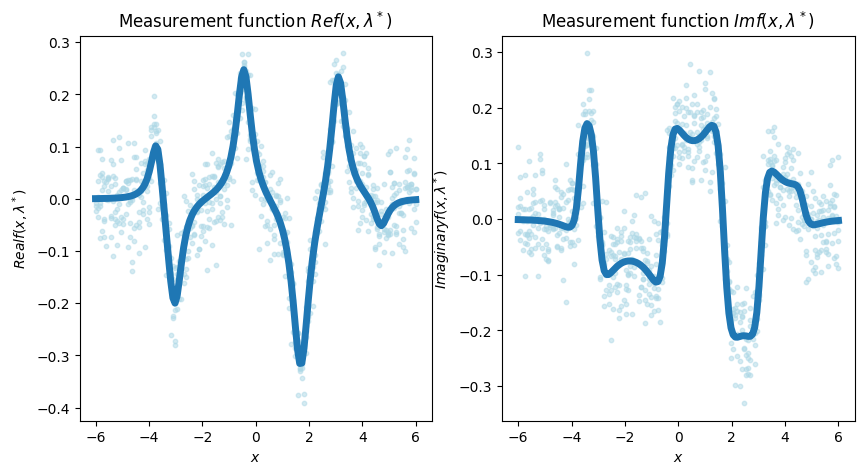

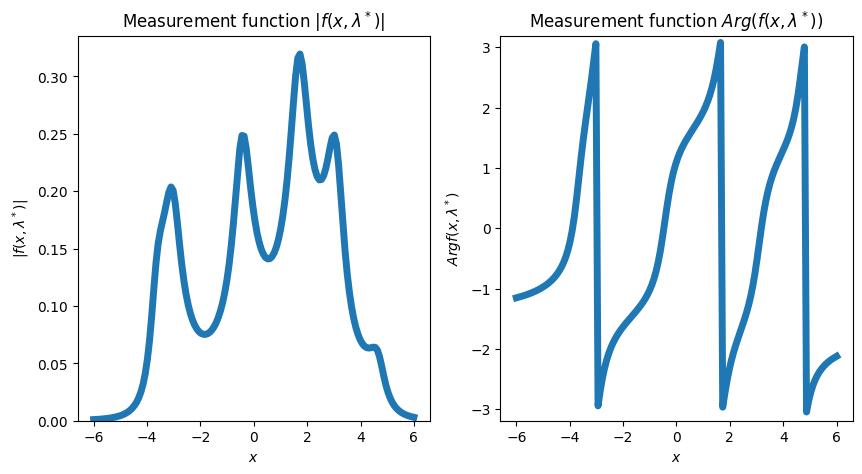

<class 'activelearning.systems.Cavities'>
dim_system               :	6
tf_real_lambda           :	[ 1.0398563   0.32585427  0.5205267   0.89986557 -0.46645802  0.00431197]
tf_coupling              :	[2.7335782 2.6151755 1.9560152 1.5678725 2.6201243]
x_range                  :	[-6, 6]

Parameters:
j_coupling               :	[2.7335782 2.6151755 1.9560152 1.5678725 2.6201243]
k_dissipation_int        :	0.5
k_dissipation_ext        :	0.5
sigma_noise              :	0.05

    


In [33]:
system.plot_response()
print(system)


### Inspect one particular run
Look at the final results of a single particular run (the first loaded)

In [34]:
system

<class 'activelearning.systems.Cavities'>
dim_system               :	6
tf_real_lambda           :	[ 1.0398563   0.32585427  0.5205267   0.89986557 -0.46645802  0.00431197]
tf_coupling              :	[2.7335782 2.6151755 1.9560152 1.5678725 2.6201243]
x_range                  :	[-6, 6]

Parameters:
j_coupling               :	[2.7335782 2.6151755 1.9560152 1.5678725 2.6201243]
k_dissipation_int        :	0.5
k_dissipation_ext        :	0.5
sigma_noise              :	0.05

    

In [35]:
al.plots.discrete_comparison(learner)


Discrete learner not calculated for <class 'activelearning.learners.BayesLearner'>


In [36]:
# Check if numerics and NN agree on IG calculation (only if discrete has been calculated)
# Accuracy problems with discrete (after a few measurements)
n_meas = 3
try:
    plt.plot(*learner.metrics[al.metrics.DiscreteExpectedInformationGainCurve.__name__][n_meas].T, label="Numerics (grid)")
    plt.plot(*learner.metrics[al.metrics.ExpectedInformationGainCurve.__name__][n_meas].T, label="NN estimate")
    # plt.plot(*np.array(learner.metrics[al.metrics.ExpectedInformationGainCurve.__name__].history)[2].T, label="NN estimate")
    plt.legend()
except:
    ...


Checking information gain behavior:

if it is too small, it's too noisy!

In [37]:
label = metrics["Active"].get_file()
system, learner, advisor = al.utils.load_all(
    al.utils.h5_get_model_path(label), load_discrete=True
)

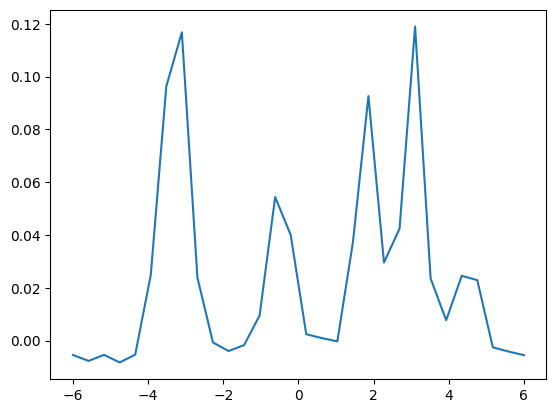

In [38]:
measurement_idx = 0
x_range, expected_ig = np.array(learner.metrics["ExpectedInformationGainCurve"][18]).T
plt.plot(
    x_range,
    expected_ig
)

### Show the final $\lambda$ distribution

Checking if the saved metric corresponds to the one calculated with the saved checkpoint. 
Just in case, you never know..

In [39]:
tf_samples_lambda = learner.prior.sample(100000)
tf_samples_lambda_mean = tf.reduce_mean(tf_samples_lambda, 0)
tf.reduce_mean(
    (tf_samples_lambda[:, None, :] - tf_samples_lambda_mean) *
    (tf_samples_lambda[:, :, None] - tf_samples_lambda_mean),
    axis=0)


<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[ 0.03847826,  0.00220303, -0.01710935, -0.0141178 ,  0.00551951,
        -0.01423382],
       [ 0.00220299,  0.01789846, -0.01961594,  0.00358529, -0.01798547,
         0.0144829 ],
       [-0.01710935, -0.01961593,  0.03581331, -0.00172603,  0.02048025,
        -0.01516754],
       [-0.0141178 ,  0.00358522, -0.00172605,  0.01211918, -0.00475371,
         0.00478134],
       [ 0.00551944, -0.01798547,  0.02048024, -0.00475358,  0.02821436,
        -0.02887297],
       [-0.01423388,  0.0144829 , -0.01516755,  0.00478143, -0.02887297,
         0.03551897]], dtype=float32)>

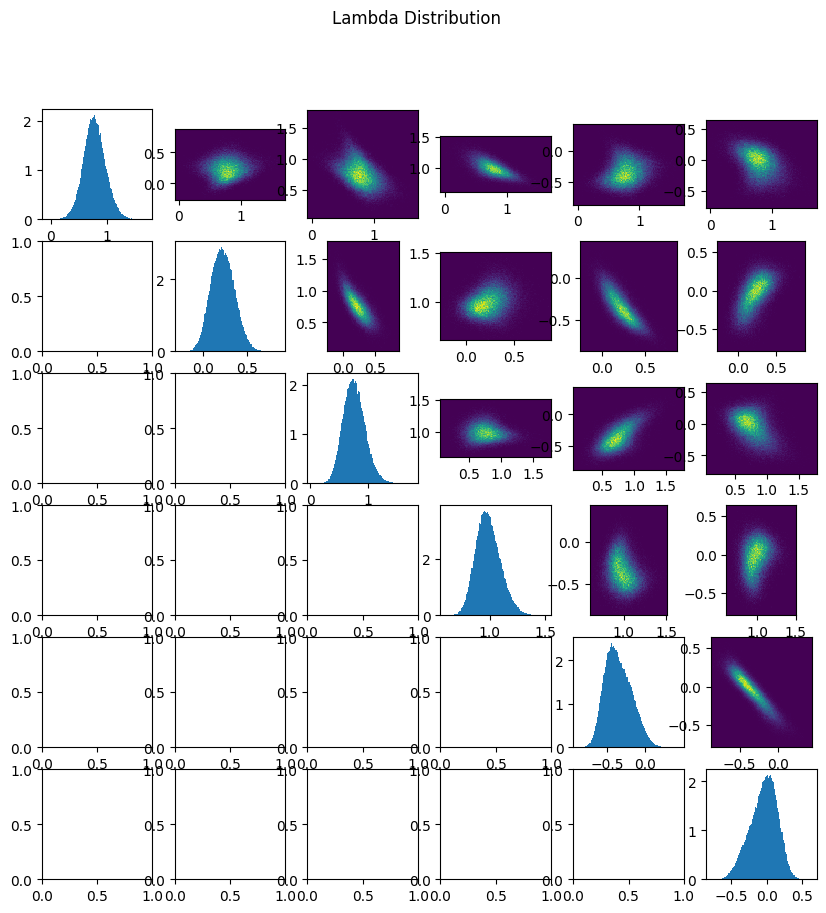

In [40]:
al.plots.distribution(learner.prior)

### Training History

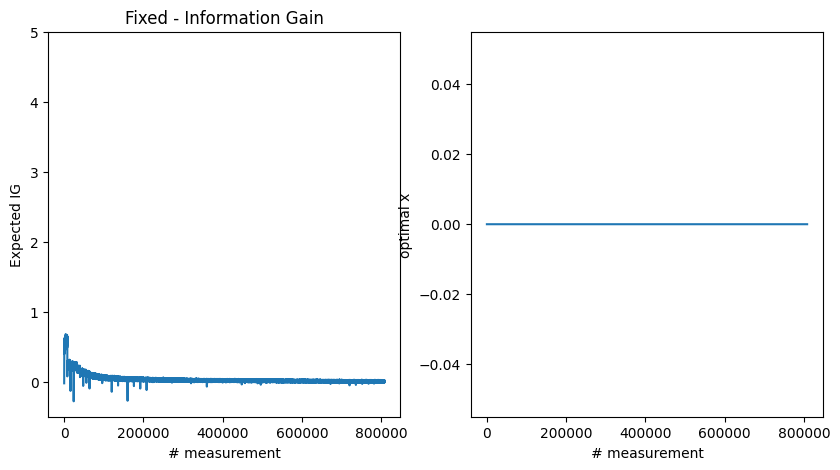

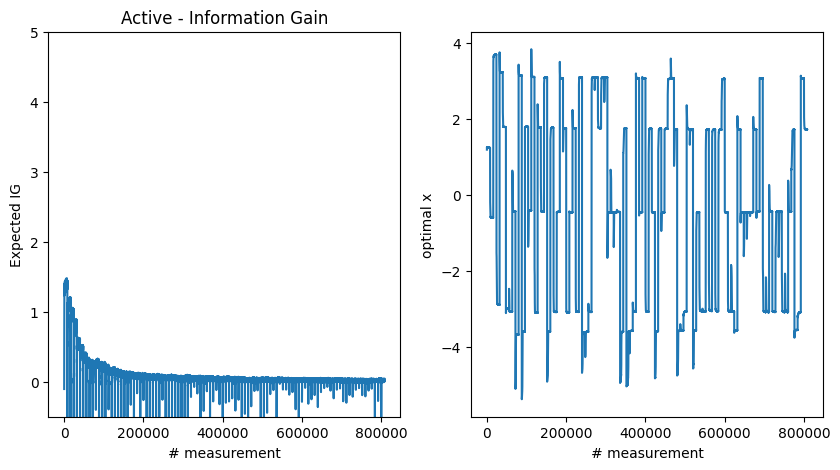

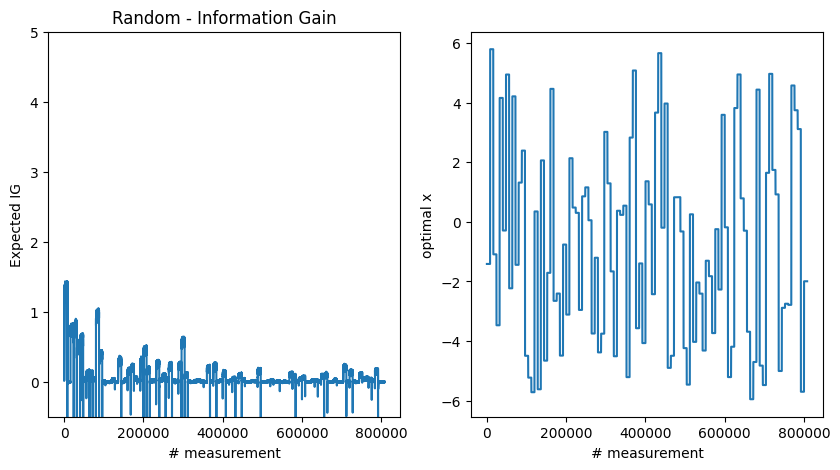

In [41]:
for metric_name, metric in metrics.items():
    # if metric_name=="Random": break
    label = metric.get_file()

    ig = {}
    with h5py.File(al.utils.h5_get_model_path(label)) as file:
        for k, v in file["advisor/training_history"].items():
            ig[k] = v[:]

    plt.figure(dpi=100, figsize=[10, 5])
    plt.subplot(1, 2, 1)
    plt.title(f"{metric_name} - Information Gain")
    plt.xlabel("# measurement")
    plt.ylabel("Expected IG")
    plt.plot(ig["information_gains"])
    plt.ylim([-0.5, 5])

    plt.subplot(1, 2, 2)
    plt.plot(ig["optimal_xs"])
    plt.xlabel("# measurement")
    plt.ylabel("optimal x")
    plt.show()


----

## Average over many runs

### Expected Information Gain
What is the information gain that we expect to get before performing each measurement?

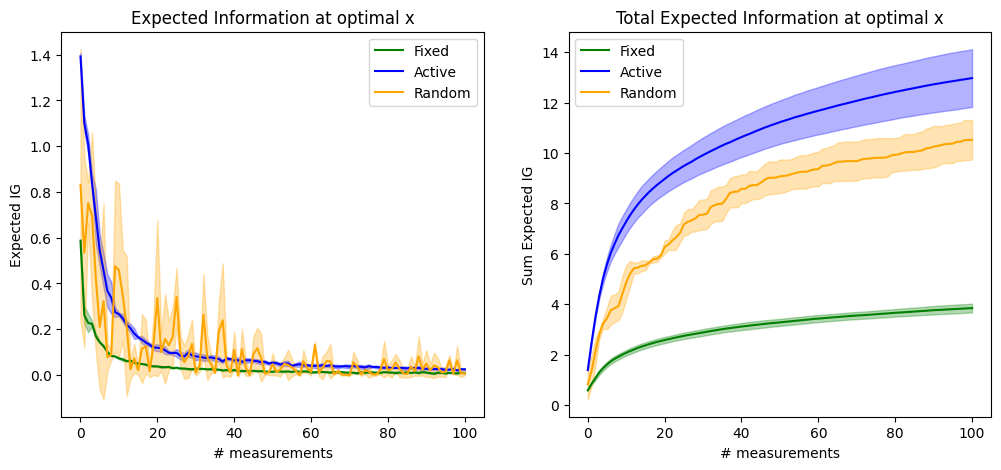

In [42]:
plt.figure(dpi=100, figsize=[12, 5])

plt.subplot(1, 2, 1)
plt.title("Expected Information at optimal x")
plt.xlabel("# measurements")
plt.ylabel("Expected IG")
for metric_name, metric in metrics.items():

    mean = metric[al.metrics.ExpectedInformationGain.__name__].mean(0)
    std = metric[al.metrics.ExpectedInformationGain.__name__].std(0)
    x = np.arange(len(mean))
    plt.plot(x, mean, label=metric_name, color=MetricsBatch.colors[metric_name])
    plt.fill_between(x, mean+std, mean-std, alpha=0.3, color=MetricsBatch.colors[metric_name])
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Total Expected Information at optimal x")
plt.xlabel("# measurements")
plt.ylabel("Sum Expected IG")
for metric_name, metric in metrics.items():

    mean = np.cumsum(metric[al.metrics.ExpectedInformationGain.__name__], 1).mean(0)
    std = np.cumsum(metric[al.metrics.ExpectedInformationGain.__name__], 1).std(0)
    x = np.arange(len(mean))
    plt.plot(x, mean, label=metric_name, color=MetricsBatch.colors[metric_name])
    plt.fill_between(x, mean+std, mean-std, alpha=0.3, color=MetricsBatch.colors[metric_name])
plt.legend()
plt.show()


### Gained Information
Effective information that would be gained between two measurements. I.e. entropy reduction before and after updating the prior distribution with the new measurement.
It can be negative because a new measurement can increase the variance of the distribution for example.

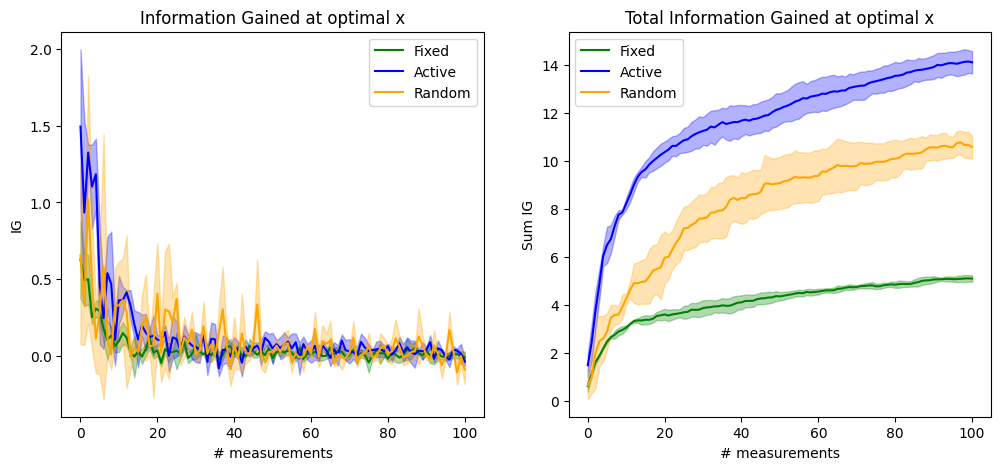

In [43]:
plt.figure(dpi=100, figsize=[12, 5])

plt.subplot(1, 2, 1)
plt.title("Information Gained at optimal x")
plt.xlabel("# measurements")
plt.ylabel("IG")
for metric_name, metric in metrics.items():

    mean = metric[al.metrics.InformationGained.__name__].mean(0)
    std = metric[al.metrics.InformationGained.__name__].std(0)
    
    x = np.arange(len(mean))
    plt.plot(x, mean, label=metric_name, color=MetricsBatch.colors[metric_name])
    plt.fill_between(x, mean+std, mean-std, alpha=0.3, color=MetricsBatch.colors[metric_name])
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Total Information Gained at optimal x")
plt.xlabel("# measurements")
plt.ylabel("Sum IG")
for metric_name, metric in metrics.items():

    mean = np.cumsum(metric[al.metrics.InformationGained.__name__], 1).mean(0)
    std = np.cumsum(metric[al.metrics.InformationGained.__name__], 1).std(0)
    x = np.arange(len(mean))
    plt.plot(x, mean, label=metric_name, color=MetricsBatch.colors[metric_name])
    plt.fill_between(x, mean+std, mean-std, alpha=0.3, color=MetricsBatch.colors[metric_name])
plt.legend()

plt.show()


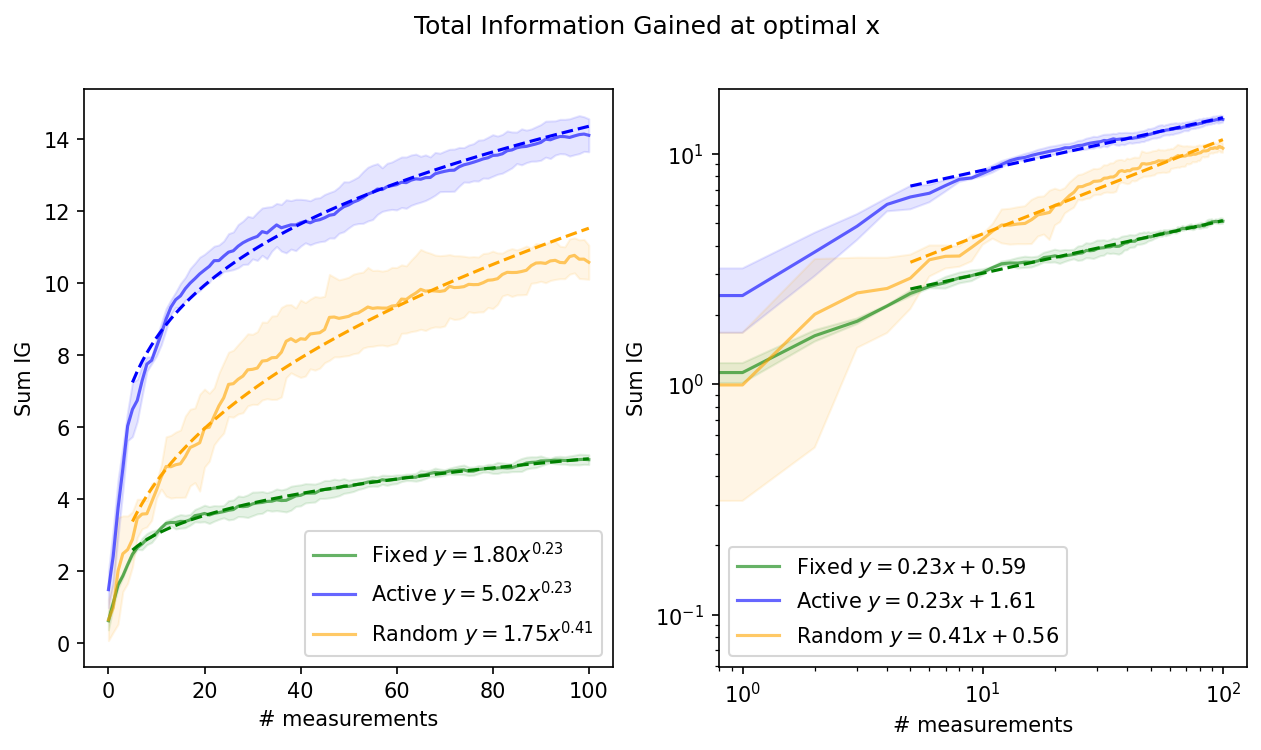

In [44]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=[10, 5])
fig.suptitle("Total Information Gained at optimal x")


asymptotic_threshold = 5
for metric_name, metric in metrics.items():
    mean = np.cumsum(metric[al.metrics.InformationGained.__name__], 1).mean(0)
    std = np.cumsum(metric[al.metrics.InformationGained.__name__], 1).std(0)
    x = np.arange(len(mean))

    mean_asymptotic = mean[asymptotic_threshold:]
    log_x = np.log(x[asymptotic_threshold:])
    log_y = np.log(mean_asymptotic)
    linear_fit = LinearRegression().fit(log_x[:, None], log_y[:, None])

    plot_labels = [f"{metric_name} $y={np.exp(linear_fit.intercept_[0]):2.2f}x^{{{linear_fit.coef_[0][0]:2.2f}}}$",
                   f"{metric_name} $y={linear_fit.coef_[0][0]:2.2f}x {linear_fit.intercept_[0]:+2.2f}$"

                   ]
    for i in range(2):
        ax[i].plot(x, mean, label=plot_labels[i], color=MetricsBatch.colors[metric_name], alpha=0.6)
        ax[i].plot(x[asymptotic_threshold:],  x[asymptotic_threshold:]**linear_fit.coef_[0][0]*np.exp(linear_fit.intercept_[0]), "--", color=MetricsBatch.colors[metric_name])

        ax[i].fill_between(x, mean+std, mean-std, alpha=0.1, color=MetricsBatch.colors[metric_name])
        ax[i].set_xlabel("# measurements")
        ax[i].set_ylabel("Sum IG")

        ax[i].legend()
ax[1].semilogx()
ax[1].semilogy()
fig.show()


### Posterior Covariance
How does the covariance of the posterior change as one performs more measurements

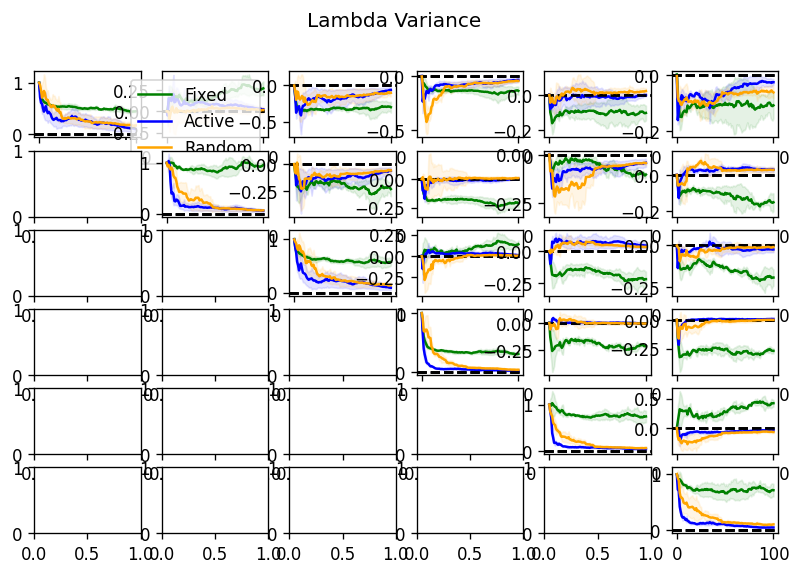

In [45]:
n_plots = metric[al.metrics.Covariance.__name__].shape[2]
fig, ax = plt.subplots(n_plots, n_plots, dpi=120, figsize=[8, 5])
fig.suptitle("Lambda Variance")

for metric_name, metric in metrics.items():
    for i in range(n_plots):
        for j in range(i, n_plots):
            mean = metric[al.metrics.Covariance.__name__].mean(0)[:, i, j]
            std = metric[al.metrics.Covariance.__name__].std(0)[:, i, j]
            x = np.arange(len(mean))
            # ax[i, j].set_title(f"Cov[{i},{j}]")
            # ax[i, j].set_xlabel("# measurement")
            # ax[i,j].set_ylabel("Variance")
            ax[i, j].axhline(0, linestyle="--", color="black")
            ax[i, j].plot(x, mean, label=metric_name, color=MetricsBatch.colors[metric_name])
            ax[i, j].fill_between(x, mean+std, mean-std, color=MetricsBatch.colors[metric_name], alpha=0.1)
            # ax[i,j].set_yscale("log")
            # ax[i,j].set_xscale("log")
ax[0, 1].legend()
plt.show()


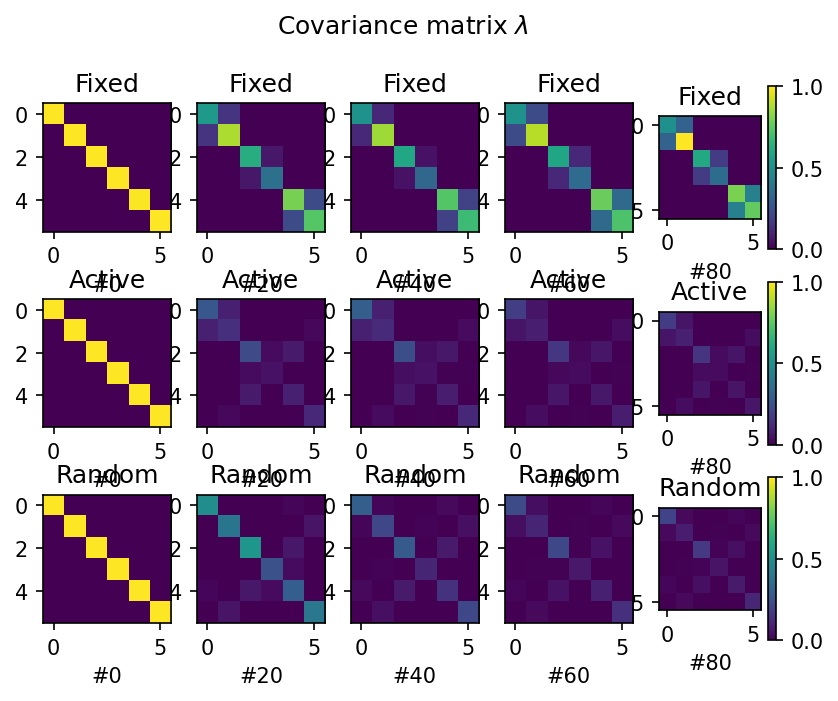

In [46]:
plt.figure(dpi=150)
plt.suptitle("Covariance matrix $\lambda$")

n_metrics = len(metrics)
n_meas = metric[al.metrics.Covariance.__name__].shape[1]
j_metric = 0
for metric_name, metric in metrics.items():

    for i in range(0, 5):
        plt.subplot(n_metrics, 5, i+1+j_metric*5)
        plt.title(metric_name)
        plt.imshow(metric[al.metrics.Covariance.__name__].mean(0)[::int(n_meas/5)][i])
        plt.clim([0, 1])
        plt.xlabel(f"#{int(n_meas/5)*i}")
    plt.colorbar()
    j_metric += 1

plt.show()


### KL-divergence with true P(y|x)
How much does the final prediction differ from the real measurement curve? If they match, we can't expect to be able to do better.

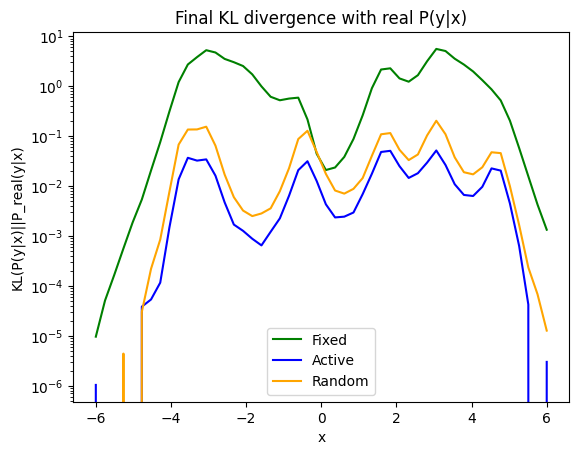

In [47]:

plt.figure(dpi=100)
plt.title("Final KL divergence with real P(y|x)")
plt.xlabel("x")
plt.ylabel("KL(P(y|x)||P_real(y|x)")
for metric_name, metric in metrics.items():
    mean = metric[al.metrics.OutputKullbackLeibler.__name__].mean(0)[-1]
    x_range = np.linspace(-6, 6, len(mean))
    plt.plot(x_range, mean,
             label=metric_name,
             color=MetricsBatch.colors[metric_name])
plt.legend()
plt.semilogy()
plt.show()


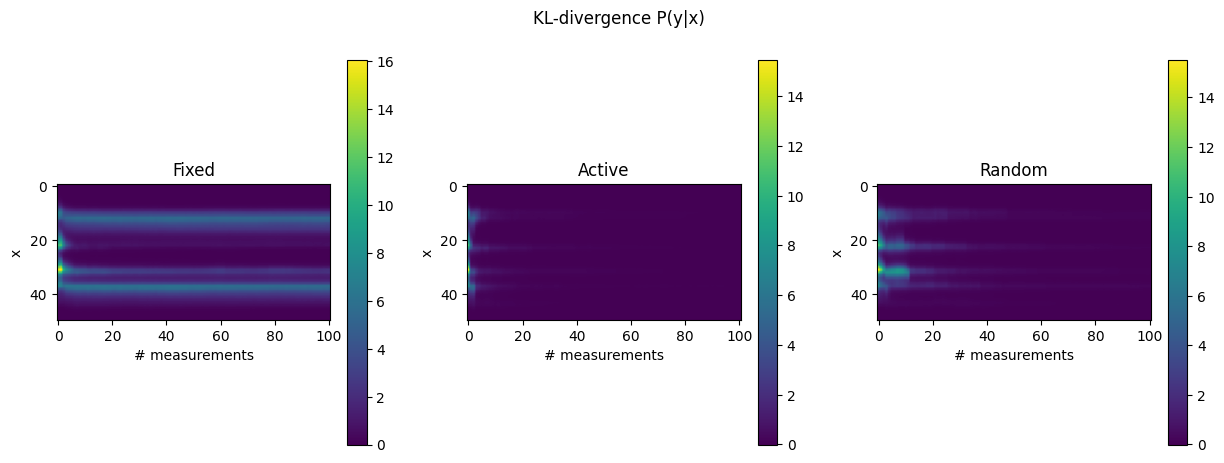

In [48]:
n_metrics = len(metrics)
i_metric = 0
fig, ax = plt.subplots(1, n_metrics, dpi=100, figsize=[15, 5])
fig.suptitle("KL-divergence P(y|x)")
for metric_name, metric in metrics.items():
    ax[i_metric].set_title(f"{metric_name}")
    ax[i_metric].set_xlabel("# measurements")
    ax[i_metric].set_ylabel("x")
    im = ax[i_metric].imshow(metric[al.metrics.OutputKullbackLeibler.__name__].mean(0).T[0])
    plt.colorbar(im, ax=ax[i_metric])
    i_metric += 1
plt.show()


---

# Plot drafts for the paper

6-cavities coupling small noise

In [29]:
default_fontsize = plt.rcParams["font.size"]
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

### Final prediction

/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


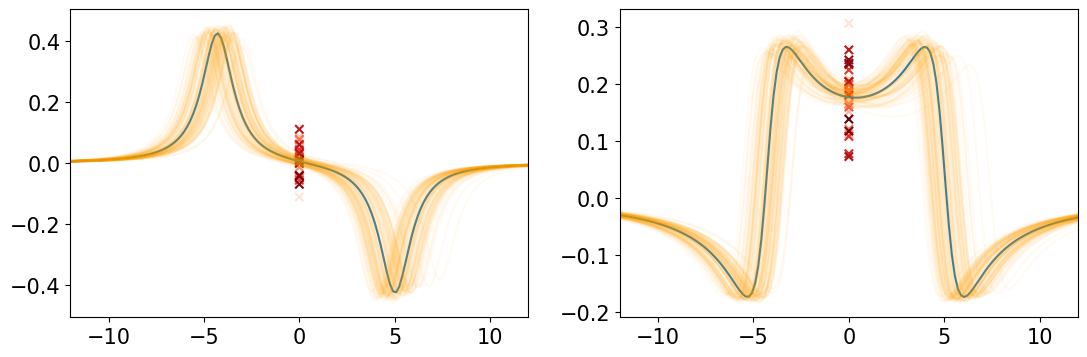

/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


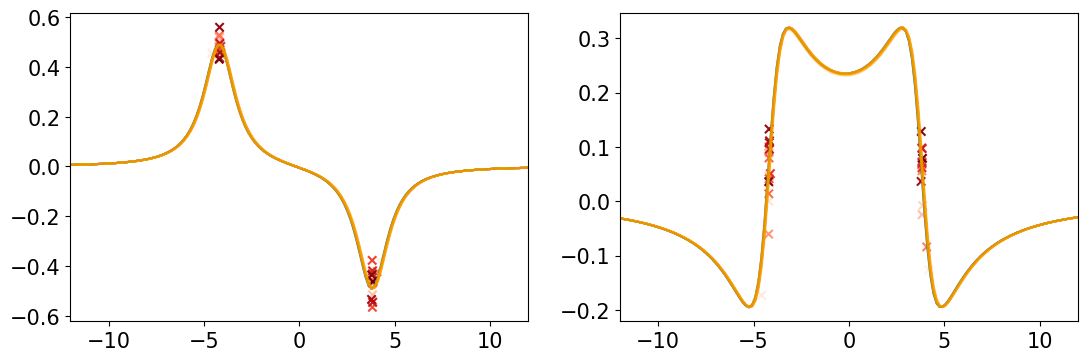

/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


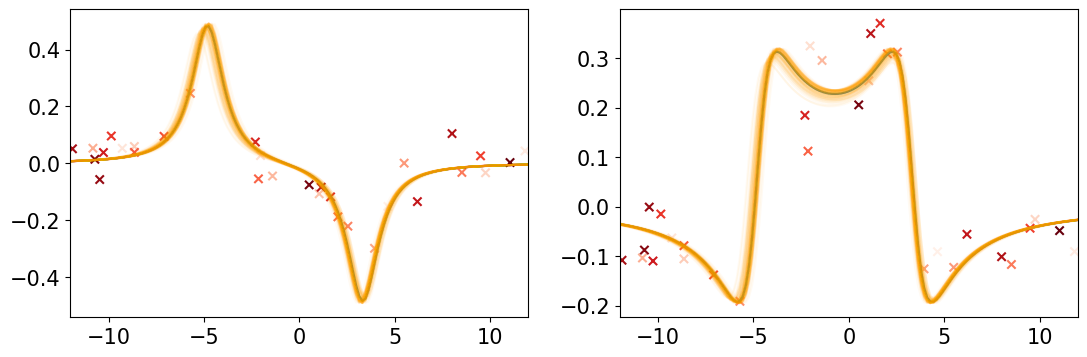

In [57]:
for metric_name, metric in metrics.items():
    idx = -1
    label = metric.get_file(batch_index=1,measurement_index=30)
    system, learner, advisor = al.utils.load_all(
        al.utils.h5_get_model_path(label), load_discrete=False
    )

    xs = np.linspace(*learner.system.x_range, 150)
    delta_xs = xs[1] - xs[0]

    batch_size = 10000
    proposed_lambdas = learner.prior.sample(batch_size)

    # Show measurement plot
    mean_lambda = tf.reduce_mean((proposed_lambdas), 0)
    std_lambda = tf.math.reduce_std((proposed_lambdas), 0)

    y_linsp = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                            learner.system.tf_real_lambda).numpy() for xxx in xs])
    y_linsp_approx = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                                    proposed_lambdas[:100, :]).numpy() for xxx in xs])
    # Divide by dissipation to make it adimensional
    plt.figure(figsize=[13, 4])
    # plt.suptitle(f"#{label} - Measurement function prediction")
    plt.tight_layout()
    plt.subplot(1, 2, 1)
    # plt.title("Real $f(x,\lambda^*)$")
    plt.plot(xs/system.p.k_dissipation_int, y_linsp[:, 0], label="True")
    plt.plot(xs/system.p.k_dissipation_int, y_linsp_approx[:, :, 0], c="orange", alpha=0.05)
    # plt.xlabel("$x$")
    # plt.ylabel("$f(x,\lambda^*)$")
    plt.xlim(learner.system.x_range[0]/system.p.k_dissipation_int,
            learner.system.x_range[1]/system.p.k_dissipation_int,)

    N_points = len(learner.history.x)
    # if N_points > 0:
    colors = plt.cm.Reds(np.linspace(0, 1, N_points + 1))
    plt.scatter(learner.history.x/system.p.k_dissipation_int, np.array(learner.history.y)[:, 0], color=colors[1:], marker="x")
    #     for i in range(N_points):
    #         plt.annotate(i,
    #                         (learner.history.x[i] + 0.05, np.array(learner.history.y)[i, 0] + 0.05))
    # plt.legend()

    plt.subplot(1, 2, 2)
    # plt.title("Imaginary $f(x,\lambda^*)$")
    plt.plot(xs/system.p.k_dissipation_int, y_linsp[:, 1], label="True")
    plt.plot(xs/system.p.k_dissipation_int, y_linsp_approx[:, :, 1], c="orange", alpha=0.05)
    # plt.xlabel("$x$")
    # plt.ylabel("$f(x,\lambda^*)$")
    plt.xlim(learner.system.x_range[0]/system.p.k_dissipation_int,
             learner.system.x_range[1]/system.p.k_dissipation_int,
             )

    # if N_points > 0:
    # colors = plt.cm.Blues(np.linspace(0, 1, N_points + 1))
    plt.scatter(learner.history.x/system.p.k_dissipation_int, np.array(learner.history.y)[:, 1], color=colors[1:], marker="x")
    #     for i in range(N_points):
    #         plt.annotate(i,
    #                         (learner.history.x[i] + 0.05, np.array(learner.history.y)[i, 1] + 0.05))
    # plt.legend()
    plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/prediction-plot{label}-{idx}.pdf")
    
    plt.show()

In [86]:
label = metrics["Active"].get_file(batch_index=1)
system, learner, advisor = al.utils.load_all(
    al.utils.h5_get_model_path(label), load_discrete=False
)

/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


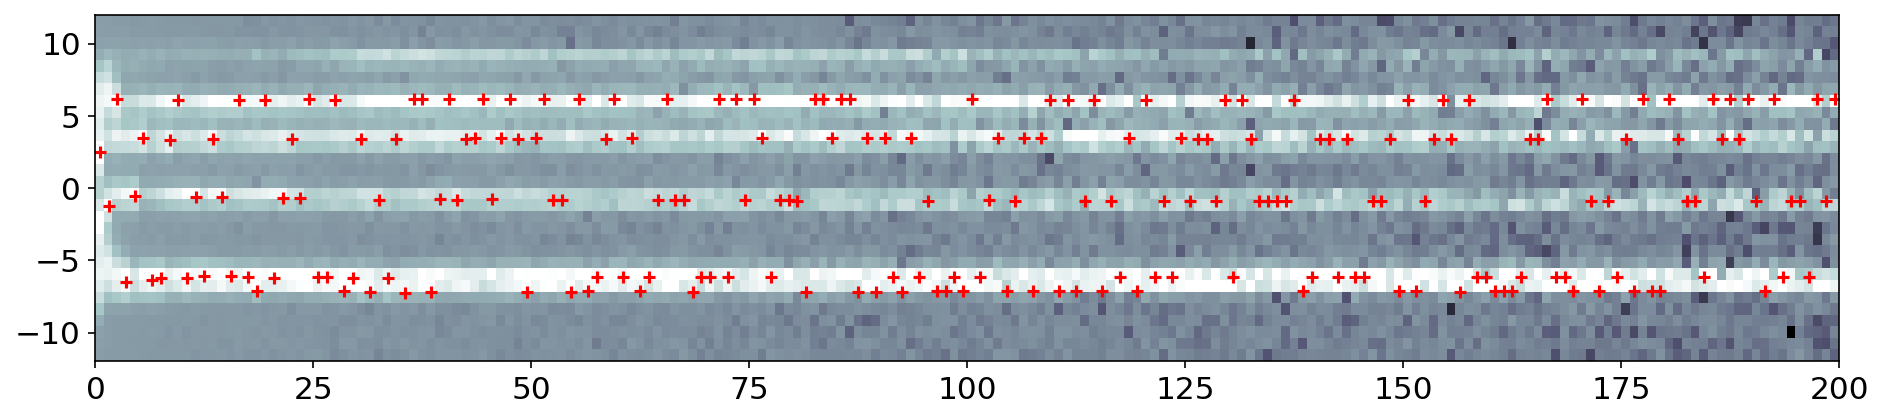

In [81]:
plt.figure(dpi=150, figsize=[15, 3])


#[n_measurement, x_vals, (x or ig)]
ordered_metric = np.array(
    learner.metrics[al.metrics.ExpectedInformationGainCurve.__name__].history
)[..., 1]

plt.imshow((np.array(ordered_metric).T / np.max(ordered_metric, 1)),
            extent=( 0, len(learner.history.x),
                    learner.system.x_range[0]/system.p.k_dissipation_int,
                    learner.system.x_range[1]/system.p.k_dissipation_int), origin="lower", aspect="auto",
            cmap="bone")
plt.scatter(np.arange(len(learner.history.x))+0.5, learner.history.x/system.p.k_dissipation_int,  c="red", marker="+")
# plt.title("Information Gain (expected at each step)")
# plt.xlabel("measured x")
# plt.ylabel("# measurement")
plt.ylim(learner.system.x_range[0]/system.p.k_dissipation_int,
        learner.system.x_range[1]/system.p.k_dissipation_int)

plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/strategy-plot{label}.pdf")
plt.show()

### Posterior distribution

In [74]:
label = metrics["Active"].get_file(batch_index=1, measurement_index=15)
system, learner, advisor = al.utils.load_all(
    al.utils.h5_get_model_path(label), load_discrete=False
)

/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


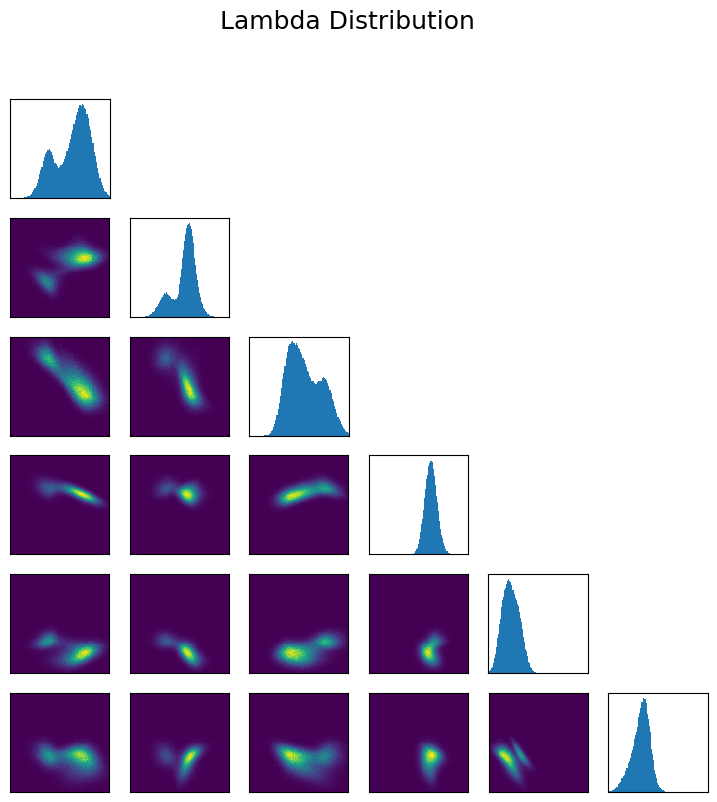

In [75]:
distr = learner.prior
n_samples = 300000
lambda_samples = distr.sample(n_samples).numpy()
n_plots = lambda_samples.shape[-1]

fig, ax = plt.subplots(n_plots,n_plots,dpi=100,figsize=[9,9])
fig.suptitle("Lambda Distribution")
for i in range(n_plots):
    for j in range(i+1,n_plots):
        ax[i,j].axis("off")
    for j in range(i+1):
        if i==j:
            ax[i,j].hist(lambda_samples[:,i],100, density=True)
            ax[i,j].set_xlim([-1.5,2.5])
        else:
            ax[i,j].hist2d(lambda_samples[:,j], lambda_samples[:,i],100, range=[[-1.5,2.5],[-1.5,2.5]])
            ax[i,j].set_aspect("equal")

            
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
fig.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/posterior_distribution-{label}.pdf")
fig.show()

### Expected information gain (x)

In [ ]:
measurement_idxs = [0,1,2,3,4,5]
measurement_idxs = [0,1,2,5,10,20,50,100]

plt.figure()
colors = plt.cm.jet(np.linspace(0,1,len(measurement_idxs)))

for idx, measurement_idx in enumerate(measurement_idxs):
    x_range, expected_ig = np.array(learner.metrics["ExpectedInformationGainCurve"][measurement_idx]).T
    plt.plot(
        x_range/0.5, # divide by dissipation for adimensional units
        expected_ig,
        label=measurement_idx,
        c=colors[idx]
    )
plt.legend()
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/expected-ig-{label}.pdf")

plt.show()

### Gained information

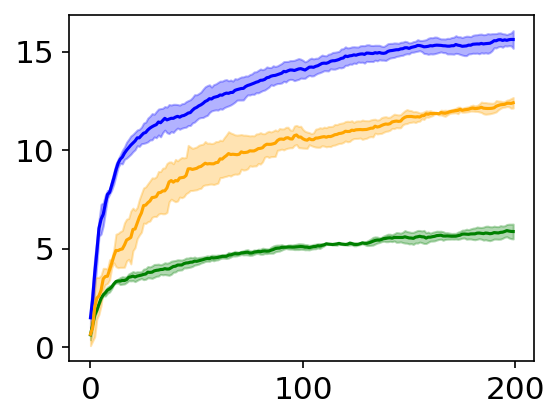

In [84]:


plt.figure(dpi=150, figsize=[4,3])
# plt.title("Total Information Gained at optimal x")
# plt.xlabel("# measurements")
# plt.ylabel("Sum IG")
for metric_name, metric in metrics.items():

    mean = np.cumsum(metric[al.metrics.InformationGained.__name__], 1).mean(0)
    std = np.cumsum(metric[al.metrics.InformationGained.__name__], 1).std(0)
    x = np.arange(len(mean))
    plt.plot(x, mean, label=metric_name, color=MetricsBatch.colors[metric_name])
    plt.fill_between(x, mean+std, mean-std, alpha=0.3, color=MetricsBatch.colors[metric_name])
# plt.legend()
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/gained_information_{label}.pdf")
plt.show()


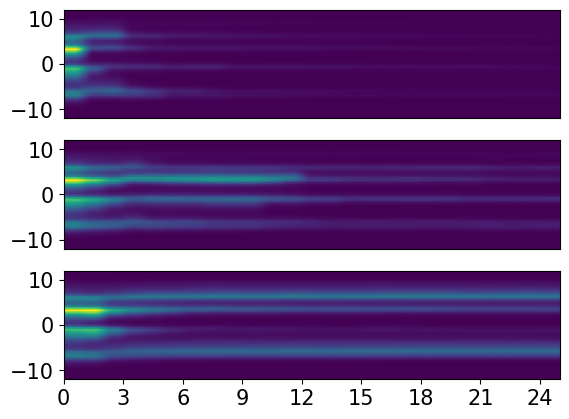

In [85]:
max_measurements=25
plt.figure()

plot_metrics = [metrics["Active"], metrics["Random"], metrics["Fixed"]]
for idx, m in enumerate(plot_metrics):
    plt.subplot(3,1,idx+1)
    # plt.title(f"{metric_name}")
    # plt.xlabel("# measurements")
    # plt.ylabel("x")
    plt.imshow(m[al.metrics.OutputKullbackLeibler.__name__].mean(0).T[0][:,:max_measurements],
               extent=( 0, max_measurements,
                       learner.system.x_range[0]/system.p.k_dissipation_int, learner.system.x_range[1]/system.p.k_dissipation_int), origin="lower", aspect="auto",)
    # plt.colorbar()
    
    plt.xticks([])
plt.xticks(np.arange(0,max_measurements,3))
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/kl_div_{label}.pdf")
plt.show()

Plot posterior evolution during time

In [17]:
prior_samples = []
for idx in trange(199):
    label = metrics["Active"].get_file(batch_index=1, measurement_index=idx)
    system, learner, advisor = al.utils.load_all(
        al.utils.h5_get_model_path(label), load_discrete=False
    )

    prior_samples.append(learner.prior.sample(100000).numpy())

  0%|          | 0/199 [00:00<?, ?it/s]/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
100%|██████████| 199/199 [05:01<00:00,  1.51s/it]


In [70]:
prior_samples_array = np.array(prior_samples)

lambda_idx = 5
n_bins = 100
l_min = -1
l_max = 1.3
dlambda = np.linspace(l_min,l_max,n_bins+1)
prior_histograms = [np.histogram(p[...,lambda_idx], n_bins,range=[l_min,l_max])[0] for p in tqdm(prior_samples_array)]
prior_histograms_array = np.array(prior_histograms)

100%|██████████| 199/199 [00:00<00:00, 630.39it/s]


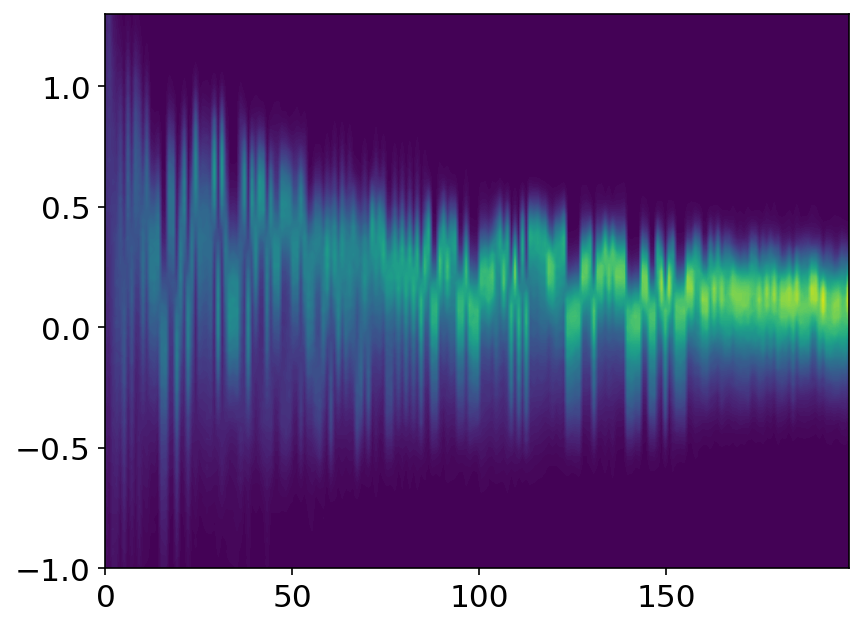

In [73]:
plt.figure(dpi=150)
plt.contourf(prior_histograms_array.T, 100, extent=[0,199, l_min,l_max])
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/prior_evolution_{label}.pdf")


# Qubits

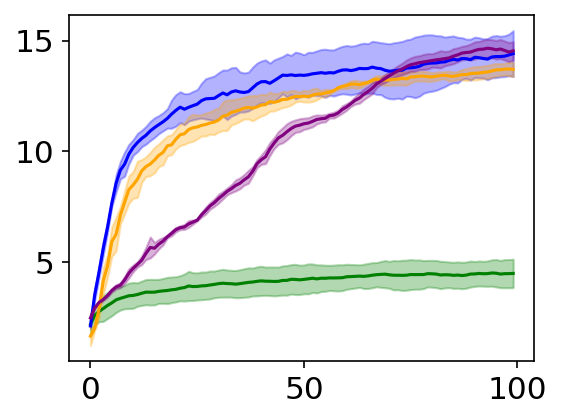

In [28]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

plt.figure(dpi=150, figsize=[4,3])
# plt.title("Total Information Gained at optimal x")
# plt.xlabel("# measurements")
# plt.ylabel("Sum IG")
for metric_name, metric in metrics.items():

    mean = np.cumsum(metric[al.metrics.InformationGained.__name__], 1).mean(0)
    std = np.cumsum(metric[al.metrics.InformationGained.__name__], 1).std(0)
    x = np.arange(len(mean))
    plt.plot(x, mean, label=metric_name, color=MetricsBatch.colors[metric_name])
    plt.fill_between(x, mean+std, mean-std, alpha=0.3, color=MetricsBatch.colors[metric_name])
# plt.legend()
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/gained_information_{label}.pdf")
plt.show()


In [ ]:
label = metrics["Active"].get_file(batch_index=0)
system, learner, advisor = al.utils.load_all(
    al.utils.h5_get_model_path(label), load_discrete=False
)

In [29]:
plt.figure(dpi=150, figsize=[6, 3])


#[n_measurement, x_vals, (x or ig)]
ordered_metric = np.array(
    learner.metrics[al.metrics.ExpectedInformationGainCurve.__name__].history
)[..., 1]

plt.imshow((np.array(ordered_metric).T)/np.array(ordered_metric).T.sum(0,keepdims=True),
            extent=( 0, len(learner.history.x),*learner.system.x_range), origin="lower", aspect="auto",
            cmap="bone")
plt.scatter(np.arange(len(learner.history.x))+0.5, learner.history.x,  c="red", marker="+")
# plt.title("Information Gain (expected at each step)")
# plt.xlabel("measured x")
# plt.ylabel("# measurement")
plt.ylim(*learner.system.x_range)

plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/strategy-plot{label}.pdf")
plt.show()

2023-06-20 21:02:08.541601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,1]
	 [[{{node Placeholder}}]]
/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
for metric_name, metric in metrics.items():
    idx = -1
    label = metric.get_file()
    system, learner, advisor = al.utils.load_all(
        al.utils.h5_get_model_path(label), load_discrete=False
    )

    xs = np.linspace(*learner.system.x_range, 150)
    delta_xs = xs[1] - xs[0]

    batch_size = 10000
    proposed_lambdas = learner.prior.sample(batch_size)

    # Show measurement plot
    mean_lambda = tf.reduce_mean((proposed_lambdas), 0)
    std_lambda = tf.math.reduce_std((proposed_lambdas), 0)

    y_linsp = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                            learner.system.tf_real_lambda).numpy() for xxx in xs])
    y_linsp_approx = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                                    proposed_lambdas[:100, :]).numpy() for xxx in xs])

    plt.figure(figsize=[7, 4])
    # plt.suptitle(f"#{label} - Measurement function prediction")
    plt.tight_layout()
    # plt.title("Real $f(x,\lambda^*)$")
    plt.plot(xs, y_linsp[:, 0, 0], label="True")
    plt.plot(xs, y_linsp_approx[:, :, 0], c="orange", alpha=0.05)
    # plt.xlabel("$x$")
    # plt.ylabel("$f(x,\lambda^*)$")
    plt.xlim(*learner.system.x_range)

    N_points = len(learner.history.x)
    # if N_points > 0:
    colors = plt.cm.Reds(np.linspace(0, 1, N_points + 1))
    plt.scatter(learner.history.x, np.clip(np.array(learner.history.y)[:, 0],0,None), color=colors[1:], marker="x")
    #     for i in range(N_points):
    #         plt.annotate(i,
    #                         (learner.history.x[i] + 0.05, np.array(learner.history.y)[i, 0] + 0.05))
    # plt.legend()

    plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/prediction-plot{label}-{idx}.pdf")
    
    plt.show()

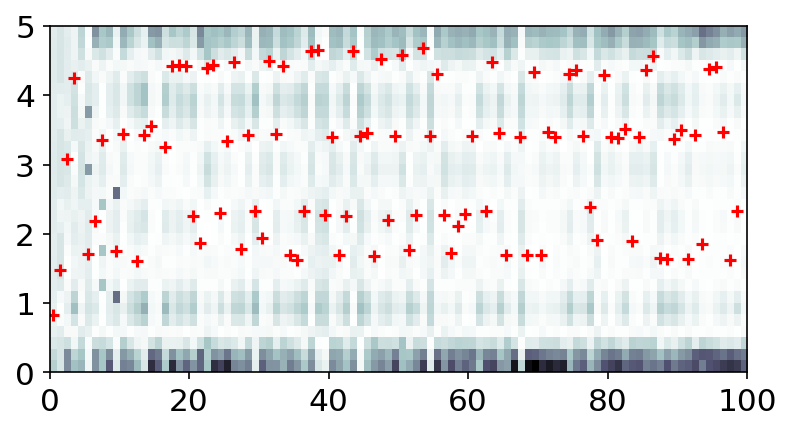

In [30]:
plt.figure(dpi=150, figsize=[6, 3])


#[n_measurement, x_vals, (x or ig)]
ordered_metric = np.clip(
    np.array(
    learner.metrics[al.metrics.ExpectedInformationGainCurve.__name__].history
)[..., 1],
    -50,None)



plt.imshow((np.array(ordered_metric).T)/np.abs((np.array(ordered_metric).T.sum(0))),
            extent=( 0, len(learner.history.x),*learner.system.x_range), origin="lower", aspect="auto",
            cmap="bone")
plt.scatter(np.arange(len(learner.history.x))+0.5, learner.history.x,  c="red", marker="+")
# plt.title("Information Gain (expected at each step)")
# plt.xlabel("measured x")
# plt.ylabel("# measurement")
plt.ylim(*learner.system.x_range)

plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/strategy-plot{label}.pdf")
plt.show()

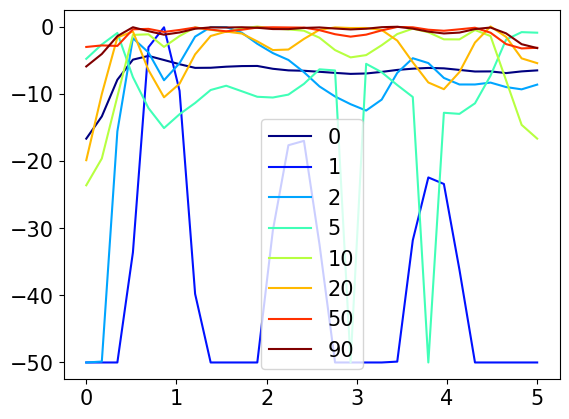

In [31]:
measurement_idxs = [0,1,2,5,10,20,50,90]
plt.figure()
colors = plt.cm.jet(np.linspace(0,1,len(measurement_idxs)))

for idx, measurement_idx in enumerate(measurement_idxs):
    x_range, expected_ig = np.array(learner.metrics["ExpectedInformationGainCurve"][measurement_idx]).T
    expected_ig = np.clip(expected_ig,-50,None)
    plt.plot(
        x_range,
        expected_ig,
        label=measurement_idx,
        c=colors[idx]
    )
plt.legend()
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/expected-ig-{label}.pdf")

plt.show()

2023-06-23 01:46:38.931618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,1]
	 [[{{node Placeholder}}]]
/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


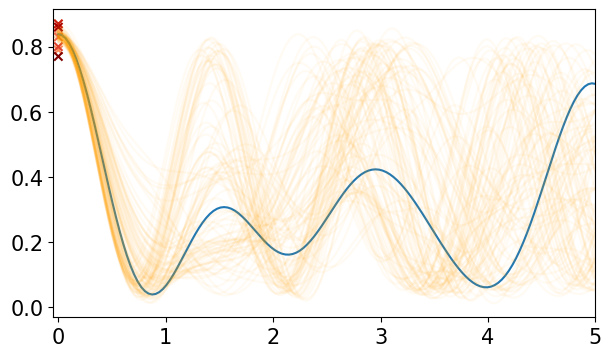

2023-06-23 01:46:59.773120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,1]
	 [[{{node Placeholder}}]]
/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


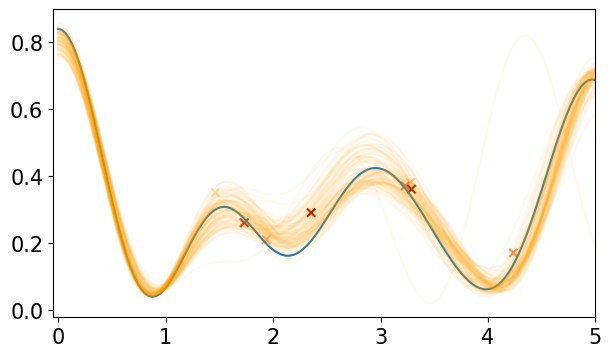

2023-06-23 01:47:19.428944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,1]
	 [[{{node Placeholder}}]]
/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


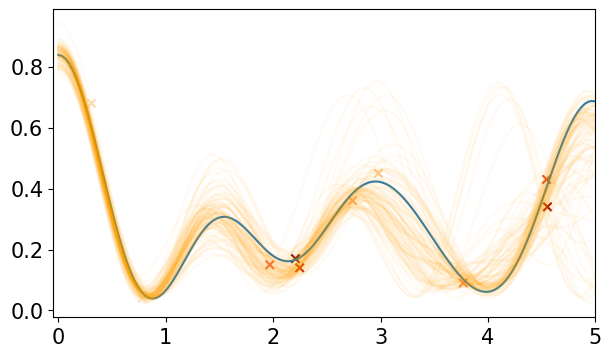

2023-06-23 01:47:39.909604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,1]
	 [[{{node Placeholder}}]]
/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


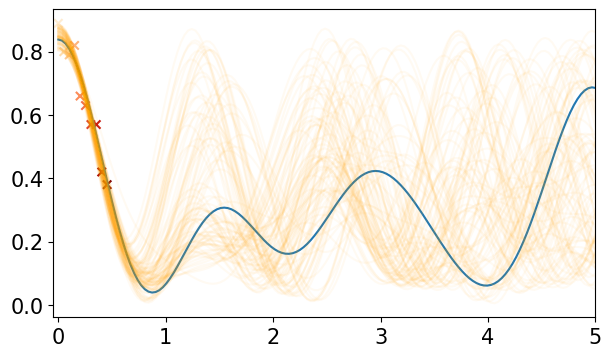

In [30]:
for metric_name, metric in metrics.items():
    idx = -1
    label = metric.get_file()
    system, learner, advisor = al.utils.load_all(
        al.utils.h5_get_model_path(label), load_discrete=False
    )

    xs = np.linspace(*learner.system.x_range, 150)
    delta_xs = xs[1] - xs[0]

    batch_size = 10000
    proposed_lambdas = learner.prior.sample(batch_size)

    # Show measurement plot
    mean_lambda = tf.reduce_mean((proposed_lambdas), 0)
    std_lambda = tf.math.reduce_std((proposed_lambdas), 0)

    y_linsp = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                            learner.system.tf_real_lambda).numpy() for xxx in xs])
    y_linsp_approx = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                                    proposed_lambdas[:100, :]).numpy() for xxx in xs])

    plt.figure(figsize=[7, 4])
    # plt.suptitle(f"#{label} - Measurement function prediction")
    plt.tight_layout()
    # plt.title("Real $f(x,\lambda^*)$")
    plt.plot(xs, y_linsp[:, 0, 0], label="True")
    plt.plot(xs, y_linsp_approx[:, :, 0], c="orange", alpha=0.05)
    # plt.xlabel("$x$")
    # plt.ylabel("$f(x,\lambda^*)$")
    plt.xlim([learner.system.x_range[0]-0.05,learner.system.x_range[1]])

    N_points = len(learner.history.x)
    # if N_points > 0:
    colors = plt.cm.OrRd(np.linspace(0, 1, N_points + 1))
    plt.scatter(learner.history.x, np.clip(np.array(learner.history.y)[:, 0],0,None), color=colors[1:], marker="x")
    #     for i in range(N_points):
    #         plt.annotate(i,
    #                         (learner.history.x[i] + 0.05, np.array(learner.history.y)[i, 0] + 0.05))
    # plt.legend()

    plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/prediction-plot{label}-{idx}.pdf")
    
    plt.show()

Multiple active plots

In [43]:
metrics["Active"].get_file(20)

'InformationGainAdvisor_646a46e9-8b99-4930-92df-2d0ef3fc17f3-020.hdf5'

/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


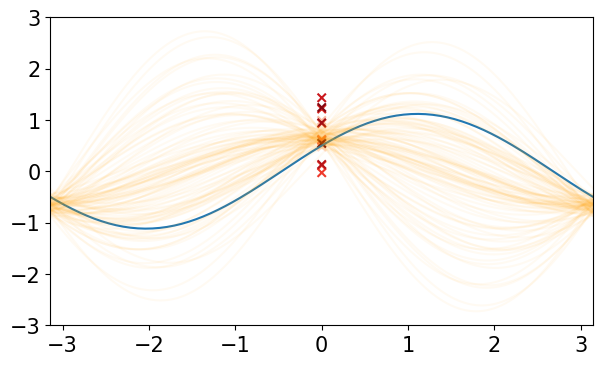

/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


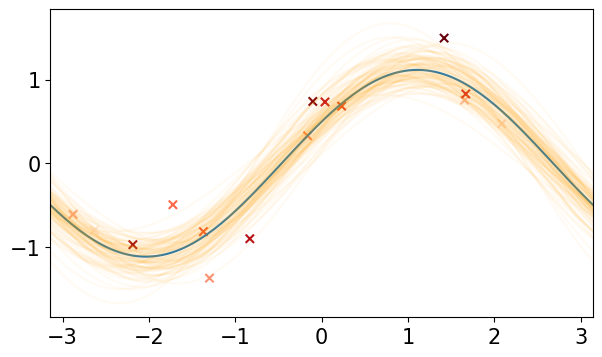

/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


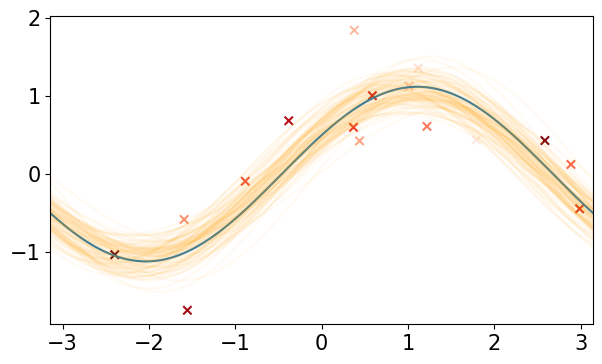

In [55]:
for metric_name, metric in metrics.items():
    idx = -1
    label = metric.get_file()
    system, learner, advisor = al.utils.load_all(
        al.utils.h5_get_model_path(label), load_discrete=False
    )

    xs = np.linspace(*learner.system.x_range, 150)
    delta_xs = xs[1] - xs[0]

    batch_size = 10000
    proposed_lambdas = learner.prior.sample(batch_size)

    # Show measurement plot
    mean_lambda = tf.reduce_mean((proposed_lambdas), 0)
    std_lambda = tf.math.reduce_std((proposed_lambdas), 0)

    y_linsp = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                            learner.system.tf_real_lambda).numpy() for xxx in xs])
    y_linsp_approx = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                                    proposed_lambdas[:100, :]).numpy() for xxx in xs])

    plt.figure(figsize=[7, 4])
    # plt.suptitle(f"#{label} - Measurement function prediction")
    plt.tight_layout()
    # plt.title("Real $f(x,\lambda^*)$")
    plt.plot(xs, y_linsp[:, 0], label="True")
    plt.plot(xs, y_linsp_approx[:,:,0], c="orange", alpha=0.05)
    # plt.xlabel("$x$")
    # plt.ylabel("$f(x,\lambda^*)$")
    plt.xlim(*learner.system.x_range)

    N_points = len(learner.history.x)
    # if N_points > 0:
    colors = plt.cm.Reds(np.linspace(0, 1, N_points + 1))
    plt.scatter(learner.history.x, np.array(learner.history.y)[:, 0], color=colors[1:], marker="x")
    #     for i in range(N_points):
    #         plt.annotate(i,
    #                         (learner.history.x[i] + 0.05, np.array(learner.history.y)[i, 0] + 0.05))
    # plt.legend()

    plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/prediction-plot{label}-{idx}.pdf")
    
    plt.show()

2023-06-23 00:36:19.075013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22793 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-06-23 00:36:19.506408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-06-23 00:36:19.532888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'binomial_noncpu/while/uniform/stateless_random_uniform/StatelessRandomUniformV2/binomial_noncpu/concat' with dtype int32 and shape [3]
	 [[{{node binomial_noncp

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-06-23 00:36:19.735725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-06-23 00:36:19.740969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-06-23 00:36:19.840562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'binomial_noncpu/batched_las_vegas_algorithm/while/uniform/stateless_random_uniform/StatelessR

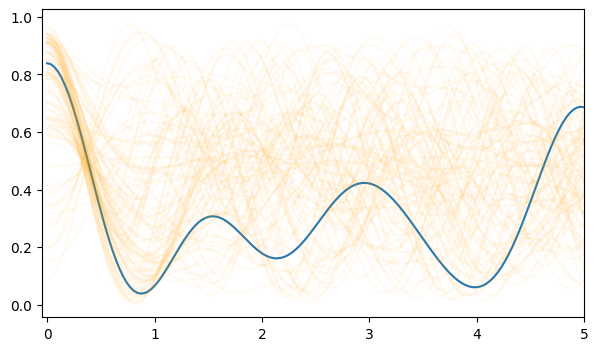

2023-06-23 00:36:44.020631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,1]
	 [[{{node Placeholder}}]]
/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


KeyboardInterrupt: 

In [23]:
for idx in [0,1,2,3,5,10,20]:
    label = f"InformationGainAdvisor_646a46e9-8b99-4930-92df-2d0ef3fc17f3-{idx:03d}.hdf5"
    system, learner, advisor = al.utils.load_all(
        al.utils.h5_get_model_path(label), load_discrete=True
    )


    xs = np.linspace(*learner.system.x_range, 150)
    delta_xs = xs[1] - xs[0]

    batch_size = 10000
    proposed_lambdas = learner.prior.sample(batch_size)

    # Show measurement plot
    mean_lambda = tf.reduce_mean((proposed_lambdas), 0)
    std_lambda = tf.math.reduce_std((proposed_lambdas), 0)

    y_linsp = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                            learner.system.tf_real_lambda).numpy() for xxx in xs])
    y_linsp_approx = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                                    proposed_lambdas[:100, :]).numpy() for xxx in xs])

    plt.figure(figsize=[7, 4])
    plt.tight_layout()
    plt.plot(xs, y_linsp[:, 0, 0], label="True")
    plt.plot(xs, y_linsp_approx[:, :, 0], c="orange", alpha=0.05)
    plt.xlim([learner.system.x_range[0]-0.05,learner.system.x_range[1]])

    N_points = len(learner.history.x)
    colors = plt.cm.OrRd(np.linspace(0, 1, N_points + 1))
    plt.scatter(learner.history.x, np.clip(np.array(learner.history.y)[:, 0],0,None), color=colors[1:], marker="x")

    plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/prediction-plot{label}-{idx}.pdf")

    plt.show()

In [73]:
plt.rcParams.update({'font.size': default_fontsize})

#### Studying behavior of 2d degenerate $P(\lambda)$

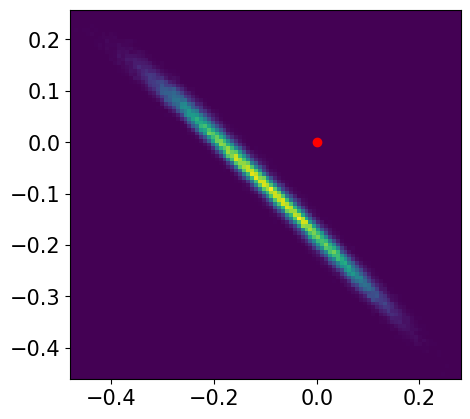

In [68]:
plt.hist2d(*learner.prior.sample(100000).numpy().T, 100)
plt.scatter(0., -0., c="red")
plt.gca().set_aspect("equal")


In [102]:
xs = np.linspace(*learner.system.x_range, 150)
delta_xs = xs[1] - xs[0]

batch_size = 10000
proposed_lambdas = tf.convert_to_tensor([[-0.25, 0.25], [0.25, -0.25]], K.backend.floatx())  # learner.prior.sample(batch_size)

# Show measurement plot
mean_lambda = tf.reduce_mean((proposed_lambdas), 0)
std_lambda = tf.math.reduce_std((proposed_lambdas), 0)

y_linsp = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                        learner.system.tf_real_lambda).numpy() for xxx in xs])
y_linsp_approx = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                               proposed_lambdas[:100, :]).numpy() for xxx in xs])


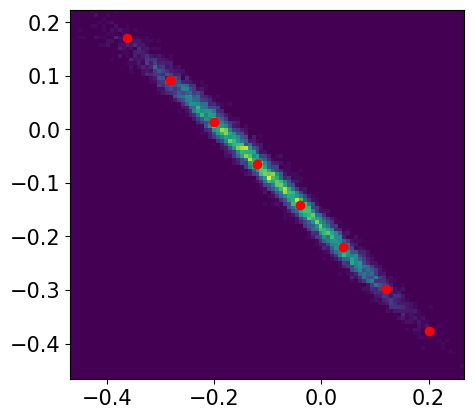

In [103]:
lambda_samples = learner.prior.sample(batch_size)
proposed_line = LinearRegression().fit(lambda_samples[:, 0][..., None], lambda_samples[:, 1][..., None])
def line(x): return x*proposed_line.coef_[0, 0] + proposed_line.intercept_[0]


plt.hist2d(*lambda_samples.numpy().T, 100)
plt.scatter(xs, line(xs), c="red")
plt.gca().set_aspect("equal")


In [104]:
proposed_line.intercept_

array([-0.18130803], dtype=float32)

In [125]:
line_x = np.linspace(-0.01, 0.01)
line_y = line(line_x) #- proposed_line.intercept_

y_linsp_approx = np.array([learner.system.tf_f(tf.convert_to_tensor(xxx, K.backend.floatx()),
                                               tf.convert_to_tensor(np.array([line_x, line_y]).T, K.backend.floatx())).numpy() for xxx in xs])


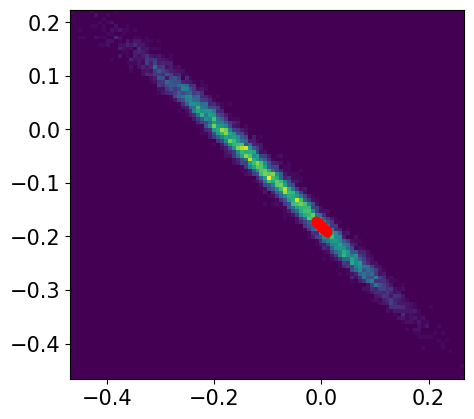

In [126]:
plt.hist2d(*lambda_samples.numpy().T, 100)
plt.scatter(line_x, line_y, c="red")
plt.gca().set_aspect("equal")


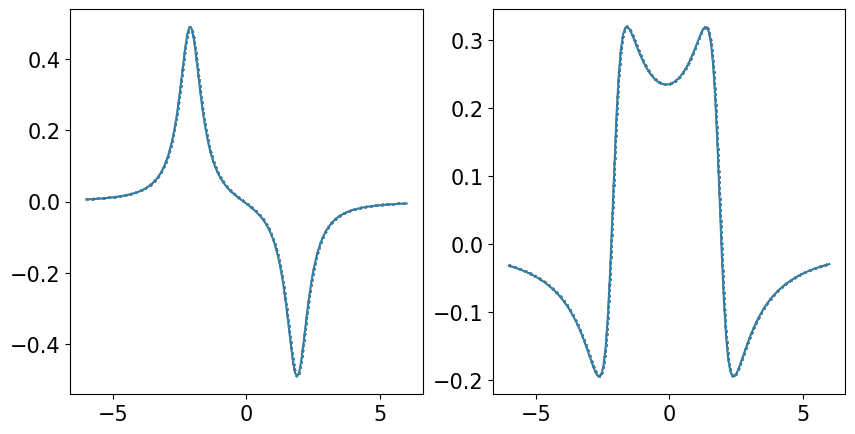

In [127]:
fig, ax = plt.subplots(1, 2, dpi=100, figsize=[10, 5])

ax[0].plot(xs, y_linsp[:, 0])
ax[1].plot(xs, y_linsp[:, 1])

ax[0].plot(xs, y_linsp_approx[..., 0], ":")
ax[1].plot(xs, y_linsp_approx[..., 1], ":")


fig.show()


### Studying Linear Toy model

Useful to test the behavior of the Bayes evolution and compare numerically
(in this case it can be estimated easily)

In [100]:
# This is the matrix x_i x_j, if x is treated as an angle
def get_chi_mat(x):
    return tf.stack([
        [tf.cos(x)**2, tf.cos(x)*tf.sin(x)],
        [tf.cos(x)*tf.sin(x), tf.sin(x)**2]
    ],0)
    # return tf.convert_to_tensor([
    #     [np.cos(x)**2, np.cos(x)*np.sin(x)],
    #     [np.cos(x)*np.sin(x), np.sin(x)**2]
    # ], K.backend.floatx())

def update_posterior_parameters(lambda_mu, lambda_sigma_inv, x, y, sigma_epsilon):
    current_x_vect = tf.convert_to_tensor([tf.cos(x), tf.sin(x)], K.backend.floatx())[:, 0]
    chi_mat = get_chi_mat(x)[..., 0]  # 3rd dimension is x batch
    
    new_lambda_sigma_inv = chi_mat/sigma_epsilon**2 + lambda_sigma_inv
    new_lambda_mu = tf.einsum("ij,j",
                              tf.linalg.inv(new_lambda_sigma_inv),
                              (y/sigma_epsilon**2*current_x_vect + tf.einsum("ij,j",lambda_sigma_inv,lambda_mu)))
    return new_lambda_mu, new_lambda_sigma_inv

@tf.function
def get_expected_information_gain(current_x, current_lambdas_mu, current_lambdas_sigma_inv, batch_size=1000000):
    sigma_noise=system.p.sigma_noise
    current_x_vect = tf.convert_to_tensor([tf.cos(current_x), tf.sin(current_x)], K.backend.floatx())[:, 0]
    
    _, new_lambda_sigma_inv = update_posterior_parameters(current_lambdas_mu, current_lambdas_sigma_inv, current_x, current_x, sigma_noise)
    prior = al.distributions.MultivariateGaussian(system.dim_lambda, 
                                                    tf.convert_to_tensor(current_lambdas_mu, K.backend.floatx()), 
                                                    tf.convert_to_tensor(tf.linalg.inv(current_lambdas_sigma_inv), K.backend.floatx()))

    likelihood = learner.likelihood


    tf_samples_lambda = prior.sample(batch_size)
    tf_H_lambda = -tf.reduce_mean(prior.log_prob(tf_samples_lambda))

    tf_samples_y_given_lambda = likelihood.sample(1,tf_x=current_x,
                                                    tf_lambda=tf_samples_lambda)[0]

    tf_lambdas_mus_given_y = tf.einsum("ij,kj-> ki",
        tf.linalg.inv(new_lambda_sigma_inv),
        (current_x_vect*tf_samples_y_given_lambda/sigma_noise**2 + tf.einsum("ij,j",current_lambdas_sigma_inv, current_lambdas_mu))
    )

    posterior = al.distributions.MultivariateGaussian(system.dim_lambda, 
                                                    tf_lambdas_mus_given_y,
                                                    tf.convert_to_tensor(tf.linalg.inv(new_lambda_sigma_inv), K.backend.floatx()))
    tf_samples_lambda_posterior = posterior.sample(1)
    tf_log_q = posterior.log_prob(tf_samples_lambda_posterior)
    tf_H_lambda_given_y = - tf.reduce_mean(tf_log_q)
    tf_IG_x = tf_H_lambda - tf_H_lambda_given_y
    return tf_IG_x


In [101]:
metric = metrics["Active"]
label = metric.get_file()
system, learner, advisor = al.utils.load_all(
    al.utils.h5_get_model_path(label), load_discrete=False
)
len(learner.history)

51

In [102]:
lambdas_mu = []
lambdas_sigma = []
gained_information = []
expected_information_gain = []
information_gain_curves = []

new_lambda_mu = tf.convert_to_tensor([1,1],dtype=K.backend.floatx())
new_lambda_sigma_inv = tf.eye(2, dtype=K.backend.floatx())

for idx in trange(len(learner.history)):
    current_x = tf.convert_to_tensor(learner.history.x[idx],K.backend.floatx())
    current_y = tf.convert_to_tensor(learner.history.y[idx],K.backend.floatx())

    current_lambdas_mu = new_lambda_mu
    current_lambdas_sigma_inv = new_lambda_sigma_inv

    new_lambda_mu, new_lambda_sigma_inv = update_posterior_parameters(
        lambda_mu=new_lambda_mu,
        lambda_sigma_inv=new_lambda_sigma_inv,
        x=current_x,
        y=current_y,
        sigma_epsilon=system.p.sigma_noise
    )
    lambdas_mu.append(new_lambda_mu),
    lambdas_sigma.append(np.linalg.inv(new_lambda_sigma_inv))
    gained_information.append(0.5*np.log(np.linalg.det(new_lambda_sigma_inv) - np.linalg.det(current_lambdas_sigma_inv)))
    expected_information_gain.append(get_expected_information_gain(
        current_x=current_x,
        current_lambdas_mu=current_lambdas_mu,
        current_lambdas_sigma_inv=current_lambdas_sigma_inv,
    ))
    
    information_gain_curves.append(tf.map_fn(lambda current_x: get_expected_information_gain(
        current_x=current_x,
        current_lambdas_mu=current_lambdas_mu,
        current_lambdas_sigma_inv=current_lambdas_sigma_inv,
    ), tf.linspace(-np.pi,np.pi,70)[:,None]))

100%|██████████| 51/51 [00:09<00:00,  5.15it/s]


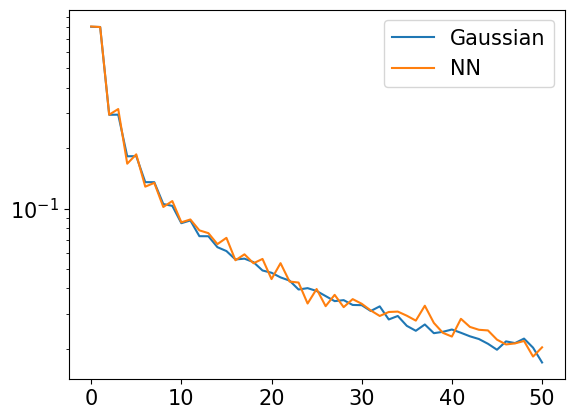

In [106]:
plt.plot(expected_information_gain, label="Gaussian")
plt.plot(learner.metrics["ExpectedInformationGain"][:], label="NN")
plt.legend()
plt.semilogy()
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/linear-toy-EIG.pdf")

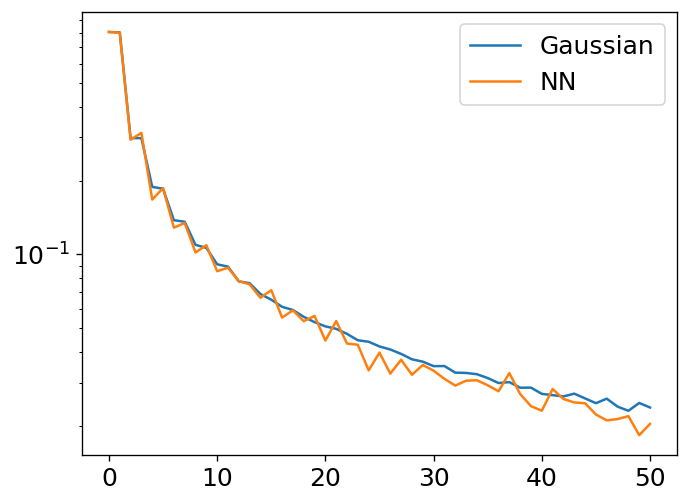

In [105]:
information_gain_curves_array = np.array(information_gain_curves)
plt.figure(dpi=120)
plt.plot(np.max(information_gain_curves_array,1), label="Gaussian")
plt.plot(learner.metrics["ExpectedInformationGain"][:], label="NN")
plt.semilogy()
plt.legend()
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/linear-toy-EIG.pdf")


In [82]:
batch_size=100000
sigma_noise = system.p.sigma_noise
current_x_vect = tf.convert_to_tensor([tf.cos(current_x), tf.sin(current_x)], K.backend.floatx())[:, 0]

prior = al.distributions.MultivariateGaussian(system.dim_lambda, 
                                                tf.convert_to_tensor(current_lambdas_mu, K.backend.floatx()), 
                                                tf.convert_to_tensor(tf.linalg.inv(current_lambdas_sigma_inv), K.backend.floatx()))

likelihood = learner.likelihood


tf_samples_lambda = prior.sample(batch_size)
tf_H_lambda = -tf.reduce_mean(prior.log_prob(tf_samples_lambda))

tf_samples_y_given_lambda = likelihood.sample(1,tf_x=current_x,
                                                tf_lambda=tf_samples_lambda)[0]

tf_lambdas_mus_given_y = tf.einsum("ij,kj-> ki",
    tf.linalg.inv(new_lambda_sigma_inv),
    (current_x_vect*tf_samples_y_given_lambda/sigma_noise**2 + tf.einsum("ij,j",current_lambdas_sigma_inv, current_lambdas_mu))
)

posterior = al.distributions.MultivariateGaussian(system.dim_lambda, 
                                                tf_lambdas_mus_given_y,
                                                tf.convert_to_tensor(tf.linalg.inv(new_lambda_sigma_inv), K.backend.floatx()))
tf_samples_lambda_posterior = posterior.sample(1)
tf_log_q = posterior.log_prob(tf_samples_lambda_posterior)

tf_H_lambda_given_y = - tf.reduce_mean(tf_log_q)
tf_IG_x = tf_H_lambda - tf_H_lambda_given_y

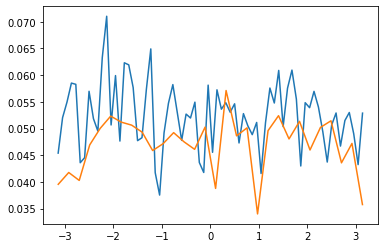

In [220]:
idx=18
plt.plot(tf.linspace(-np.pi,np.pi,70),information_gain_curves_array[idx],label="Gaussian")
plt.plot(*np.array(learner.metrics["ExpectedInformationGainCurve"].history[idx].T), label="NN")


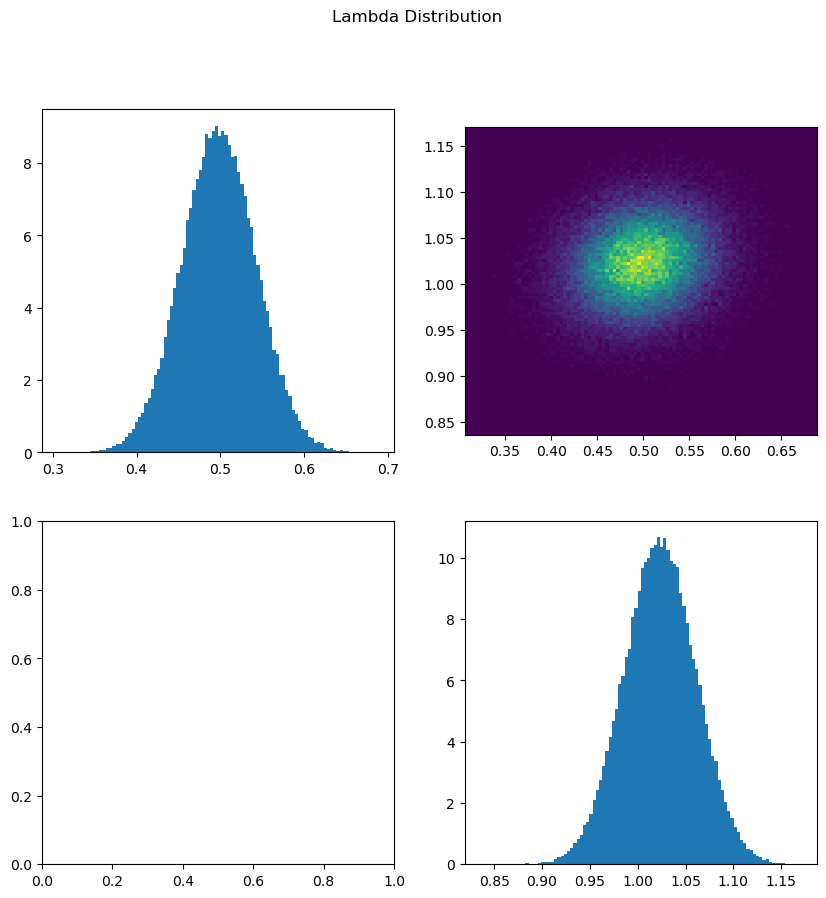

In [51]:
posterior = al.distributions.MultivariateGaussian(system.dim_lambda, 
                                                  tf.convert_to_tensor(lambdas_mu[-1], K.backend.floatx()), 
                                                  tf.convert_to_tensor(lambdas_sigma[-1], K.backend.floatx()))

al.plots.distribution(posterior)

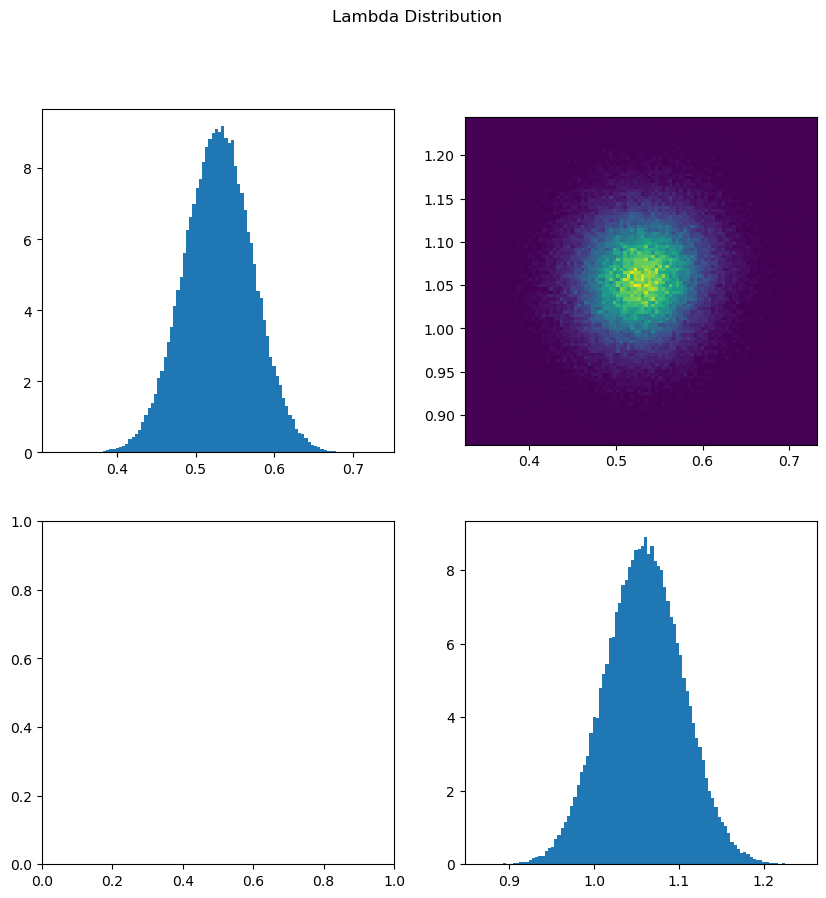

In [52]:
idx = 300
metric = metrics["Active"]
label = metric.get_file(idx)
system, learner, advisor = al.utils.load_all(
    al.utils.h5_get_model_path(label), load_discrete=False
)

al.plots.distribution(learner.prior)

In [53]:
np.mean(learner.prior.sample(100000).numpy().T,-1), np.cov(learner.prior.sample(100000).numpy().T)

(array([0.5290236, 1.0589074], dtype=float32),
 array([[0.00191199, 0.00014368],
        [0.00014368, 0.0020891 ]]))

Compare the results between the Gaussian model and the NN one, using the NN measurements

In [115]:
learner_mus = []

system, learner, advisor = al.utils.load_all(
    al.utils.h5_get_model_path(metric.get_file()), 
)

for idx in trange(len(learner.history)):
    label = metric.get_file(idx)
    system, learner, advisor = al.utils.load_all(
        al.utils.h5_get_model_path(label), load_discrete=False
    )
    learner_mus.append(np.mean(learner.prior.sample(500000).numpy().T,-1))
    
learner_mus_array = np.array(learner_mus)

/u/lsarra/conda-envs/tensor2/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
100%|██████████| 51/51 [01:05<00:00,  1.28s/it]


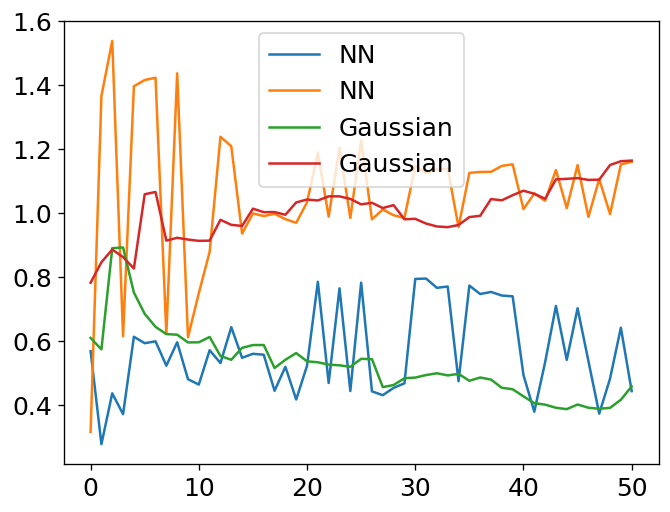

In [116]:
plt.figure(dpi=120)
plt.plot(learner_mus, label="NN")
plt.plot(lambdas_mu, label = "Gaussian")
plt.legend()
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/linear-toy-MUS.pdf")

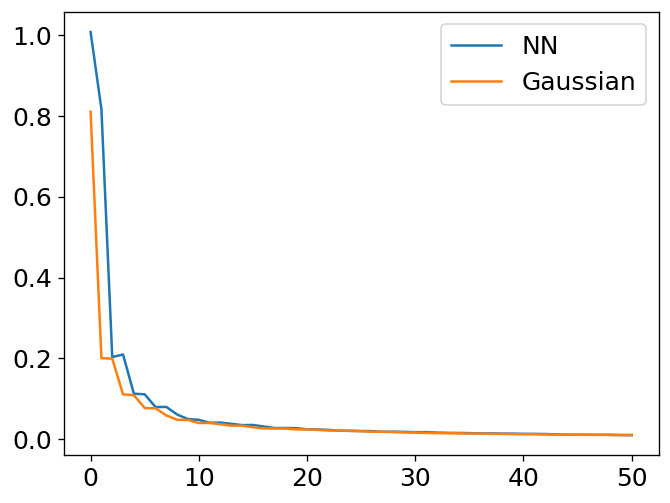

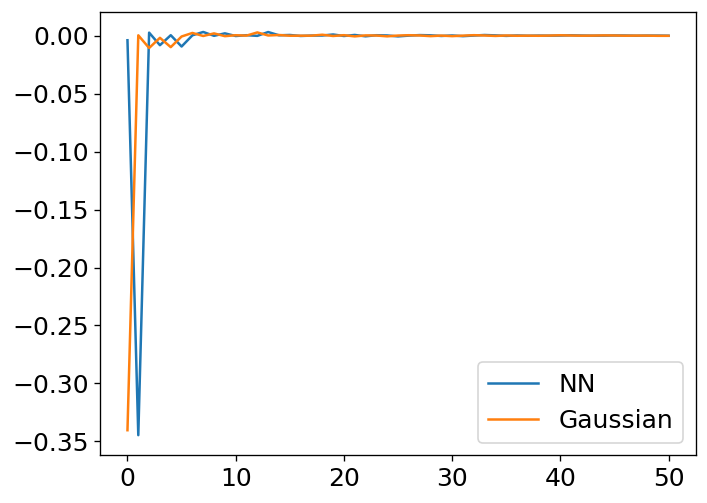

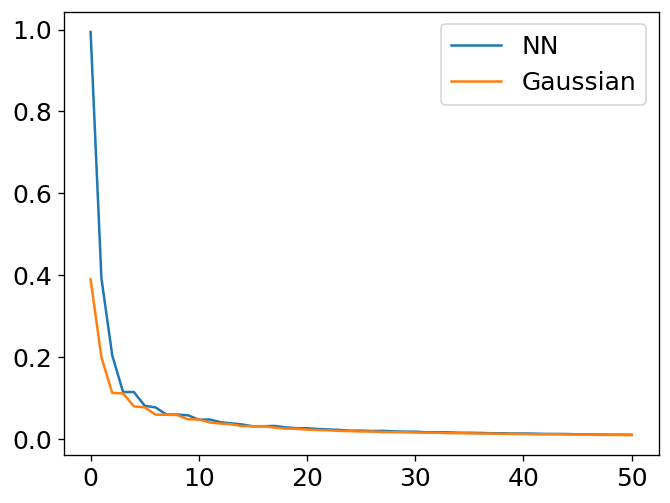

In [114]:
plt.figure(dpi=120)
plt.plot(np.array(learner.metrics["Covariance"].history)[:,1,1], label="NN")
plt.plot(np.array(lambdas_sigma)[:,1,1], label="Gaussian")
plt.legend()
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/linear-toy-SIGMAS11.pdf")
plt.show()


plt.figure(dpi=120)
plt.plot(np.array(learner.metrics["Covariance"].history)[:,0,1], label="NN")
plt.plot(np.array(lambdas_sigma)[:,0,1], label="Gaussian")
plt.legend()
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/linear-toy-SIGMAS01.pdf")
plt.show()


plt.figure(dpi=120)
plt.plot(np.array(learner.metrics["Covariance"].history)[:,0,0], label="NN")
plt.plot(np.array(lambdas_sigma)[:,0,0], label="Gaussian")
plt.legend()
plt.savefig(f"{al.config.Directories().PATH_OUTPUT_FIGURES}/linear-toy-SIGMAS00.pdf")
plt.show()
